# Example: Estimating Single Index Models (SIMs) from Historical Data
The direct computation of the expected returns $\mathbb{E}(r_{i})$ of the covariance matrix $\Sigma$ in the _data-driven_ Minimum-Variance (Markowitz) portfolio problem can be computationally heavy as the number of assets in the portfolio grows. An alternative is to use index models to compute the expected returns and the covariance. 

### Single index model of Sharpe
A single index model describes the return of a firm’s stock (or the return of an ETF) in terms of a firm-specific return and the overall market return. One of the simplest (yet still widely used) single index models was developed by [Sharpe (1963)](https://en.wikipedia.org/wiki/Single-index_model#:~:text=The%20single%2Dindex%20model%20(SIM,used%20in%20the%20finance%20industry.)).

Let $R_{i}(t)\equiv\left(r_{i}\left(t\right) - r_{f}\right)$ 
and $R_{m}(t)\equiv\left(r_{m}\left(t\right)-r_{f}\right)$ denote the firm-specific and market **excess returns**, where $r_{f}$ denotes the risk-free rate of return.
Further, let $\epsilon_{i}\left(t\right)$ denote stationary normally distributed random noise
with mean zero and standard deviation $\sigma_{i}$. Then, the single index model of Sharpe is given by:
$$
\begin{equation*}
R_{i}\left(t\right) = \alpha_{i}+\beta_{i}\cdot{R}_{m}\left(t\right)+\epsilon_{i}
\left(t\right)\qquad{t=1,2,\dots,T}
\end{equation*}
$$
where $\alpha_{i}$ and $\beta_{i}$ are (unknown) model parameters: 
* $\alpha_{i}$ describes the firm-specific return not explained by the market; thus, $\alpha_{i}$ is the idiosyncratic return of firm $i$.
* $\beta_{i}$ has two interpretations. First, it measures the relationship between the excess return of firm $i$ and the excess return of the market. 
A large $\beta_{i}$ suggests that the market returns (or losses) are amplified for firm $i$, while a small $\beta_{i}$ indicates that the market returns (or losses) are damped for firm $i$. 
Second, it represents the relative risk of investing in a firm $i$ relative to the overall market.

### Learning objectives
In this `worked example`, we'll estimate the $\left(\alpha_{i},\beta_{i}\right)$ parameters for the single index model for each asset in our historical collection of assets, we'll visualize the signal index model performance versus the data. Finally, we'll save the single index model parameters to a file so we can use them later.

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `10-31-2023`.
* __Task 1__: Next, we'll estimate the $\left(\alpha_{i},\beta_{i}\right)$ parameters for each asset in our collection. 
* __Task 2__: Then, we'll compute the error term for the single index model for each asset in our collection and visualize the return distribution of the data versus the single index model.
* __Task 3__: Finally, we'll save the parameter(s) and error model to disk so that we can use them later.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

### Types
The `MySingleIndexModel` type, which encodes data associated with the Single Index Model (SIM) of Sharpe, that we'll use in this example has the fields:
```julia
mutable struct MySingleIndexModel <: AbstractReturnModel

    # model -
    α::Float64          # firm-specific unexplained return
    β::Float64          # relationship between the firm and the market
    r::Float64          # risk-free rate of return 
    ϵ::Distribution     # error distribution capturing random shocks 

    # constructor -
    MySingleIndexModel() = new()
end
```

### Functions
In `Lab 12b` we introduce a few new functions that are useful when working with single index models. 

> `function sample_sim_model(model::MySingleIndexModel, Rₘ::Array{Float64,1}; 
    number_of_paths::Int64 = 100) -> Array{Float64,2}` samples the `MySingleIndexModel` instance, generating `number_of_paths` sample from the error model
    
> `function evaluate_sim_model(model::MySingleIndexModel, Rₘ::Array{Float64,1}) -> Array{Float64,1}` is a helper function to evaluate the single index model described in `model::MySingleIndexModel`.

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `10-31-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [2]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array

In [5]:
all_tickers = keys(dataset) |> collect |> sort;

Finally, let's set some constant values, e.g., a value for the `risk_free_rate`:

In [6]:
risk_free_rate = 0.05;

## Task 1: Estimate SIM parameters for each asset in our collection

### Compute the expected return for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ will be used in our single index model calculations, so we'll provide values for these items for the entire dataset (all `N = 459` tickers).

* First, compute the expected (annualized) log excess return by passing the `dataset`, the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_tickers` array) and the annualized risk-free rate to the `log_return_matrix(...)` method. 
* The result will be stored in the `all_firms_excess_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_excess_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [7]:
all_firms_excess_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = 0.05);

Next, we estimate the expected return for each firm from the `all_firms_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(r_{1}),\dotsc,\mathbb{E}(r_{N})$ in the variable $\mu$:

In [8]:
μ = mean(all_firms_excess_return_matrix, dims=1) |> vec;

### `TODO` Estimate $\left(\alpha_{i},\beta_{i}\right)$ values for each firm in the dataset
First, to estimate the single index model parameters, initialize some storage. We'll store `MySingleIndexModel` instances for each firm in `dataset` in the `sim_model_dictionary::Dict{String, MySingleIndexModel}` dictionary:

In [9]:
sim_model_dictionary = Dict{String, MySingleIndexModel}();

Next, we need to pull out the excess return of the `market portfolio` from `all_firms_excess_return_matrix`. To do this, look up the index for our market portfolio surrogate `SPY,` then get this column of data from the `all_firms_excess_return_matrix.` We'll store the excess return data for `SPY` in the `Rₘ` variable:

In [10]:
index_spy = findfirst(x->x=="SPY",all_tickers);
Rₘ = all_firms_excess_return_matrix[:,index_spy];

Finally, for each `ticker` in the `all_tickers` array, compute the values for the $(\alpha,\beta)$ parameters using a `for` loop. For each iteration of the loop:
* First, look up the index of the `ticker` we are considering and store that in the `asset_ticker_index` variable. Then, store the appropriate column from `all_firms_excess_return_matrix` in the `Rᵢ` variable.
* Next, compute the number of trading days of data we have, and formulate the data array `X` and the output array `Y` for `ticker` that we will use to solve the `normal equations`.
* Finally, solve for the unknown parameter vector $\theta$, create a `MySingleIndexModel` instance for each ticker, populate the fields of this model, and store in the `sim_model_dictionary`.

In [11]:
for asset_ticker ∈ all_tickers
    
    # compute the excess return for asset_ticker -
    asset_ticker_index = findfirst(x->x==asset_ticker, all_tickers);
    Rᵢ = all_firms_excess_return_matrix[:, asset_ticker_index];
    
    # formulate the Y and X arrays with the price data -
    max_length = length(Rᵢ);
    Y = Rᵢ;
    X = [ones(max_length) Rₘ];
    
    # compute θ -
    θ = inv(transpose(X)*X)*transpose(X)*Y
    
    # package -
    sim_model = MySingleIndexModel();
    sim_model.α = θ[1];
    sim_model.β = θ[2];
    sim_model.r = risk_free_rate;
    sim_model_dictionary[asset_ticker] = sim_model;
end

## Task 2: Compute the SIM error model for each asset in our collection
Now that we values for the $(\alpha,\beta)$ parameters for each firm, we can compute the error models. In particular, the parameters in the error can be estimated by computing the residual vector:

$$\Delta_{i} = R_{i} - \hat{R}_{i}$$

where $R_{i}$ denotes the `observed` excess return and $\hat{R}_{i}$ represents the excess return `predicted` using the single index model. Using a ' for ' loop, we need to do this for each firm in our `dataset`. In particular, for each `ticker` in the `all_tickers` array:

* First, we get the `MySingleIndexModel` instance from `sim_model_dictionary`, and store this model in the `sim_model` variable. Then, store the appropriate column from `all_firms_excess_return_matrix` in the `Rᵢ` variable.
* Next, compute the number of trading days of data we have, access the $(\alpha, \beta)$ parameter values from `sim_model,` compute the `predicted` excess return, and store this in the `R̂ᵢ` variable.
* Finally, compute the residual values $\Delta_{i} = R_{i} - \hat{R}_{i}$, fit a `Normal` distribution to the residuals using the `fit_mle(...)` function exported by [Distributions.jl](https://github.com/JuliaStats/Distributions.jl.git), and store both the fitted distribution and residual values.

In [12]:
residual_model_dictionary = Dict{String, Array{Float64,1}}()
for asset_ticker ∈ all_tickers
    
    # grab the model -
    sim_model = sim_model_dictionary[asset_ticker];
    
    # compute the excess return for asset_ticker -
    asset_ticker_index = findfirst(x->x==asset_ticker, all_tickers);
    Rᵢ = all_firms_excess_return_matrix[:, asset_ticker_index];
    
    # what is the length -
    max_length = length(Rᵢ);
    
    # compute the model excess return -
    αᵢ = sim_model.α
    βᵢ = sim_model.β
    R̂ᵢ = αᵢ .+ βᵢ .* Rₘ
    
    # compute the residual -
    Δᵢ = Rᵢ .- R̂ᵢ;
    
    # Esimate a distribution -
    d = fit_mle(Normal, Δᵢ);
    
    # update the sim_model -
    sim_model.ϵ = d;
    
    # store the residuals -
    residual_model_dictionary[asset_ticker] = Δᵢ
end

### Visualize residual models

In [13]:
test_ticker = "INTC"
index_test_ticker = findfirst(x->x==test_ticker,all_tickers);
ϵᵢ = sim_model_dictionary[test_ticker] |> x-> x.ϵ
Δᵢ = residual_model_dictionary[test_ticker];

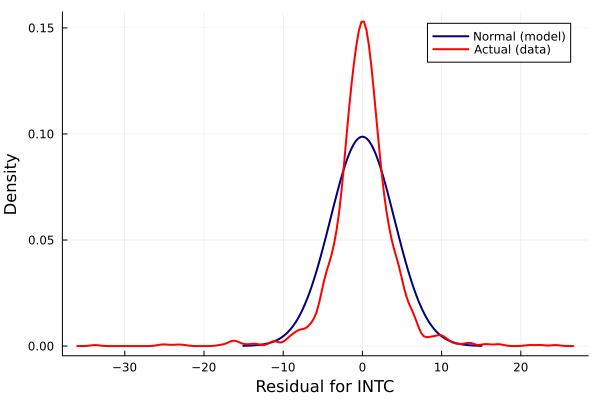

In [14]:
plot(ϵᵢ, label="Normal (model)", c=:navyblue,lw=2)
density!(Δᵢ, normalize=true, xlabel="Residual for $(test_ticker)", 
    ylabel="Density", label="Actual (data)", c=:red,lw=2)

### Visualize SIM model performance versus `SPY` excess return

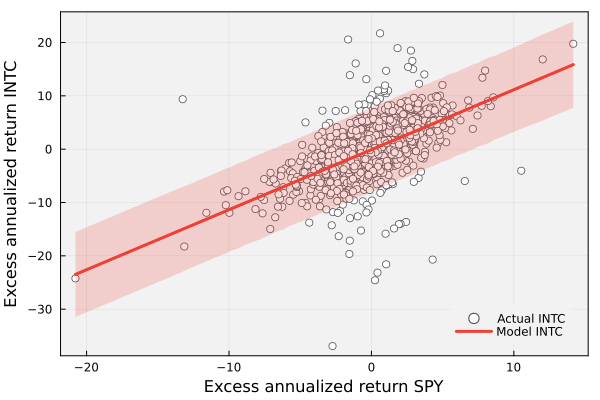

In [15]:
let 
    # pick an asset -
    sim_model = sim_model_dictionary[test_ticker];

    # compute the excess return for asset_ticker (data) -
    test_asset_ticker_index = findfirst(x->x==test_ticker, all_tickers);
    Rᵢ = all_firms_excess_return_matrix[:, test_asset_ticker_index];

    # evaluate the SIM (without noise) -> expected return
    R̂ᵢ = sim_model(sort(Rₘ));

    # sample the SIM to get the uncertainty region -
    R̂ᵢ_samples = sim_model(sort(Rₘ), 10000);

    # data and expected value -
    scatter(Rₘ, Rᵢ, mc=colorant"#FFFFFF", msc=colorant"#55565A", 
        label="Actual $(test_ticker)", legend=:bottomright)

    # uncertainty region -
    L = R̂ᵢ .- 1.96*std(R̂ᵢ_samples,dims=2)
    U = R̂ᵢ .+ 1.96*std(R̂ᵢ_samples,dims=2)

    plot!(sort(Rₘ), R̂ᵢ, fillrange=U, fillalpha = 0.2, lw=2, label="", c=colorant"#EF4035")
    plot!(sort(Rₘ), R̂ᵢ, fillrange=L, fillalpha = 0.2, lw=2, label="", c=colorant"#EF4035")

    plot!(sort(Rₘ), R̂ᵢ, lw=3, c=colorant"#EF4035", bg=colorant"#F2F2F2", 
        background_color_outside="white", framestyle = :box, 
        fg_legend = :transparent, label="Model $(test_ticker)")

    # labels -
    xlabel!("Excess annualized return SPY",fontsize=18)
    ylabel!("Excess annualized return $(test_ticker)",fontsize=18)
end

#### Compare the mean and standard deviation for a specified ticker in the collection
`Check`: Generally, a single index model can reproduce the expected return and the volatility (the standard deviation of the return). Let's use the `@assert(isapprox(...))` construct to test the `closeness` of the expected excess return and the volatility.

In [16]:
sim_model = sim_model_dictionary[test_ticker];
test_ticker_index = findfirst(x->x==test_ticker,all_tickers)

expected_Rₘ = mean(Rₘ);
αᵢ = sim_model.α
βᵢ = sim_model.β
expected_Rᵢ = αᵢ + βᵢ*expected_Rₘ
σᵢ = std(all_firms_excess_return_matrix[:,test_ticker_index]) |> x-> x*sqrt(1/252); # annualized
σₘ = std(Rₘ);
σₑ = sim_model.ϵ |> x-> params(x) |> x-> x[2]
σsim = (βᵢ^2)*(σₘ^2)+(σₑ^2) |> sqrt |> x-> x*sqrt(1/252); # annualized

##### `Test` expected excess return:

In [17]:
@assert(isapprox(μ[test_ticker_index],expected_Rᵢ,atol=1e-3))

##### `Test` Volatility:

In [18]:
@assert(isapprox(σᵢ,σsim,atol=1e-3))

## Task 3: Save the parameter(s) and error model
First, we specify a `path` in the `path_to_save_file` variable:

In [19]:
path_to_save_file = joinpath(_PATH_TO_DATA,"SIMs-SP500-01-03-18-to-12-01-23.jld2");

Then we write a `HDF5 binary file` holding our data to location specified by `path_to_save_file`. To read and write this binary format, we use the `save(...)` function exported by the [JLD2.jl](https://github.com/JuliaIO/JLD2.jl.git) package:

In [20]:
save(path_to_save_file, Dict("sim"=>sim_model_dictionary));

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.